# 4. Random Forest modeling

In [1]:
# import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools       # called by function pulled from RandomForest_casestudy_covid19 that plots confusion matrix
import numpy as np

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## 4.1 Load and inspect data

Available sets are:

- X_train.zip, y_train.zip

- X_train_subsample.zip, y_train_subsample.zip

- X_test.zip, y_test.zip

The subsample set only subsamples the 'good' class (1 out of every 15), to try to balance the classes better (1.5:1  good:bad).

In [3]:
# also set probeset_id as the index.  Will propagate to all derived dataframes.
X_train_subsample_raw = pd.read_csv('../data/X_train_subsample.zip',sep='\t', index_col = 'probeset_id')

#y_train should be a Series, so extract the only column from the loaded DataFrame
y_train_subsample = pd.read_csv('../data/y_train_subsample.zip',sep='\t', index_col = 'probeset_id').quality_binary_good

In [4]:
X_train_subsample_raw.shape, y_train_subsample.shape

((60274, 38), (60274,))

In [5]:
X_train_subsample_raw.isnull().sum()

CR                                       0
FLD                                   2763
HetSO                                 2743
MMD                                  36597
het_frac                                 0
MinorAlleleFrequency                     0
H.W.p-Value                              0
AA.meanX.clean                       21591
AB.meanX.abs_clean                    2743
BB.meanX.clean                       14843
HomRO                                   20
AA.meanY.clean                       21591
AB.meanY.clean                        2743
BB.meanY.clean                       14843
meanY                                    0
Hom.meanY.delta                          0
AA.varX.clean                        21591
AB.varX.clean                         2743
BB.varX.clean                        14843
AA.varY.clean                        21591
AB.varY.clean                         2743
BB.varY.clean                        14843
OriginalCT.recommended_True              0
OriginalCT_

In [6]:
y_train_subsample.value_counts()

1    36102
0    24172
Name: quality_binary_good, dtype: int64

In [7]:
# Software that computes most of these feature values has a pre-existing classifier.
X_train_subsample_raw['OriginalCT.recommended_True'].value_counts()

1    44686
0    15588
Name: OriginalCT.recommended_True, dtype: int64

Confusion matrix
[[14722  9450]
 [  866 35236]]


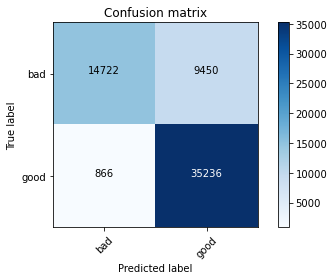

In [8]:
# Let's see if the model can do a better job predicting y_train than just this single feature:
# sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
cm_single_feature = confusion_matrix(y_train_subsample, X_train_subsample_raw['OriginalCT.recommended_True'])
plt.figure()
plot_confusion_matrix(cm_single_feature, classes=['bad','good'], title='Confusion matrix')

## 4.2 Fill missing values

RandomForestClassifier can't handle missing values.  For these metrics, the missing values aren't so much "missing" as that they cannot be calculated for certain categories of observations.  Replacing these empty values with mean or median is very likely not appropriate.  Since these sparse metrics are used to segregate good from bad groups, let's replace empty values with either a floor or ceiling value.

For example, small FLD is a sign of a problem.  If this metric isn't available, replace with a value larger than any real value, like '999'

For example, large variance is a sign of a problem.  If these metrics aren't available, replace with a value smaller than any real value, like '0'.

Since feature rescaling is not needed for RandomForestClassifier and will not be done, the distance of the replacement values from the real distribution should not matter.

Comments on specific columns:
HomRO is NA for probesets where there is no Hom cluster (het_frac=1).  These should all be bad.  Set HomRO to bad negative value.


In [9]:
X_train_subsample = X_train_subsample_raw.copy()

fill_lo_columns = ['BB.meanX.clean','HomRO']
fill_0_columns = ['AB.meanX.abs_clean','AA.varX.clean','AB.varX.clean','BB.varX.clean','AA.varY.clean','AB.varY.clean','BB.varY.clean']
fill_hi_columns = ['AA.meanX.clean','FLD','HetSO','MMD','AA.varY.clean','AB.varY.clean','BB.varY.clean']

X_train_subsample[fill_lo_columns] = X_train_subsample_raw[fill_lo_columns].fillna(-999)
X_train_subsample[fill_0_columns ] = X_train_subsample_raw[fill_0_columns ].fillna( 0  )
X_train_subsample[fill_hi_columns] = X_train_subsample_raw[fill_hi_columns].fillna( 999)

In [10]:
X_train_subsample.isnull().sum().sort_values(ascending=False).head()

AA.meanY.clean    21591
BB.meanY.clean    14843
AB.meanY.clean     2743
CR                    0
BB.varY.clean         0
dtype: int64

In [11]:
# This Cell doesn't change anything, no errors.
# Fill empty cluster position values with the minimum or maximum (as appropriate) of two other columns.
# Reminder: the .clean suffix means the value is empty if there there is no data underlying the metric

X_train_subsample['AA.meanY.clean'] = X_train_subsample_raw[['AA.meanY.clean']].\
                                          fillna(X_train_subsample_raw[['AB.meanY.clean','BB.meanY.clean']].min(axis=1))
X_train_subsample['BB.meanY.clean'] = X_train_subsample_raw[['BB.meanY.clean']].\
                                          fillna(X_train_subsample_raw[['AA.meanY.clean','AB.meanY.clean']].min(axis=1))
X_train_subsample['AB.meanY.clean'] = X_train_subsample_raw[['AB.meanY.clean']].\
                                          fillna(X_train_subsample_raw[['AA.meanY.clean','BB.meanY.clean']].max(axis=1))

#test = X_train_subsample_raw[['AA.meanY.clean']]. \
#     fillna(value= X_train_subsample_raw[['AB.meanY.clean','BB.meanY.clean']].groupby(level=0).min())

In [12]:
X_train_subsample.isnull().sum().sort_values(ascending=False).head()

AA.meanY.clean    21591
BB.meanY.clean    14843
AB.meanY.clean     2743
CR                    0
BB.varY.clean         0
dtype: int64

Why didn't DataFrame.fillna() work?

In [13]:
# https://stackoverflow.com/questions/48171256/pandas-replace-nan-with-values-from-one-of-two-columns
#Using pandas.Series.fillna to update single column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.fillna.html

# Fill empty cluster position values with the minimum or maximum (as appropriate) of two other columns.
# Reminder: the .clean suffix means the value is empty if there there is no data underlying the metric

X_train_subsample['AA.meanY.clean'] = X_train_subsample_raw['AA.meanY.clean'].\
                                          fillna(X_train_subsample_raw[['AB.meanY.clean','BB.meanY.clean']].min(axis=1))
X_train_subsample['BB.meanY.clean'] = X_train_subsample_raw['BB.meanY.clean'].\
                                          fillna(X_train_subsample_raw[['AA.meanY.clean','AB.meanY.clean']].min(axis=1))
X_train_subsample['AB.meanY.clean'] = X_train_subsample_raw['AB.meanY.clean'].\
                                          fillna(X_train_subsample_raw[['AA.meanY.clean','BB.meanY.clean']].max(axis=1))

In [14]:
# check that removed all NaNs in DataFrame
X_train_subsample.isnull().sum().sort_values(ascending=False).head()

CR                             0
OriginalCT_BBvarianceY         0
BB.varY.clean                  0
OriginalCT.recommended_True    0
OriginalCT_AAvarianceX         0
dtype: int64

In [15]:
X_train_subsample_raw.loc['AX-31964699'].head(14)

CR                      100.000000
FLD                       3.683000
HetSO                     0.215000
MMD                            NaN
het_frac                  0.025362
MinorAlleleFrequency      0.013000
H.W.p-Value               1.000000
AA.meanX.clean                 NaN
AB.meanX.abs_clean        0.097000
BB.meanX.clean           -1.472000
HomRO                     1.472000
AA.meanY.clean                 NaN
AB.meanY.clean           11.096000
BB.meanY.clean           10.958000
Name: AX-31964699, dtype: float64

In [16]:
# looks like filled values are calculated appropriately
X_train_subsample.loc['AX-31964699'].head(14)

CR                      100.000000
FLD                       3.683000
HetSO                     0.215000
MMD                     999.000000
het_frac                  0.025362
MinorAlleleFrequency      0.013000
H.W.p-Value               1.000000
AA.meanX.clean          999.000000
AB.meanX.abs_clean        0.097000
BB.meanX.clean           -1.472000
HomRO                     1.472000
AA.meanY.clean           10.958000
AB.meanY.clean           11.096000
BB.meanY.clean           10.958000
Name: AX-31964699, dtype: float64

In [17]:
# I'll be reusing filling of empty values
def mydata_fillna(X):
    X_filled = X.copy()
    
    fill_lo_columns = ['BB.meanX.clean','HomRO']
    fill_0_columns = ['AB.meanX.abs_clean','AA.varX.clean','AB.varX.clean','BB.varX.clean', \
                      'AA.varY.clean','AB.varY.clean','BB.varY.clean']
    fill_hi_columns = ['AA.meanX.clean','FLD','HetSO','MMD','AA.varY.clean','AB.varY.clean','BB.varY.clean']
    
    X_filled[fill_lo_columns] = X[fill_lo_columns].fillna(-999)
    X_filled[fill_0_columns ] = X[fill_0_columns ].fillna( 0  )
    X_filled[fill_hi_columns] = X[fill_hi_columns].fillna( 999)    
    X_filled['AA.meanY.clean'] = X['AA.meanY.clean'].fillna(X[['AB.meanY.clean','BB.meanY.clean']].min(axis=1))
    X_filled['BB.meanY.clean'] = X['BB.meanY.clean'].fillna(X[['AA.meanY.clean','AB.meanY.clean']].min(axis=1))
    X_filled['AB.meanY.clean'] = X['AB.meanY.clean'].fillna(X[['AA.meanY.clean','BB.meanY.clean']].max(axis=1))
    
    return X_filled

## 4.3 Load and fill missing values for remaining data

In [18]:
# Load full (unbalanced) training set. Same "bad" observations as X_train_subsample, but 15x as many "good" observations.
# this has same proportion of classes as test set, which is also loaded.

X_train_raw = pd.read_csv('../data/X_train.zip',sep='\t', index_col = 'probeset_id')
X_test_raw  = pd.read_csv('../data/X_test.zip' ,sep='\t', index_col = 'probeset_id')

#y_train should be a Series, so extract the only column from the loaded DataFrame
y_train = pd.read_csv('../data/y_train.zip',sep='\t', index_col = 'probeset_id').quality_binary_good
y_test  = pd.read_csv('../data/y_test.zip' ,sep='\t', index_col = 'probeset_id').quality_binary_good

In [19]:
X_train = mydata_fillna(X_train_raw)
X_test = mydata_fillna(X_test_raw)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((565708, 38), (565708,), (242447, 38), (242447,))

In [21]:
y_train.value_counts()

1    541536
0     24172
Name: quality_binary_good, dtype: int64

## 4.4 First model

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- n_estimators:  number of trees in the forest (100 default)
- criterion:  measuring quality of split ('gini' default)
- max_features: per-node random selection of this many features (default is sqrt of n_feature, so ~6 in this case)
- n_jobs (default 1.  Set to -1 to use all available processors)
- random_state: set to a value to give same results each time run

### 4.4.1 train on subsampled balanced classes

In [22]:
# 90 estimators is sufficient for perfect prediction accuracy in the subsample training set
# As go higher in estimators, get better prediction accuracy for withheld good class in full training set
model = RandomForestClassifier(random_state=1,n_jobs=-1,n_estimators=500)
model.fit(X_train_subsample,y_train_subsample);

In [23]:
# X_train_subsample has ~balanced classes
# Let's see what overfitting looks like (recalculatate for different n_estimators in previous cell)
y_train_subsample_prediction = model.predict(X_train_subsample)
cm_train_subsample = confusion_matrix(y_train_subsample, y_train_subsample_prediction)

Confusion matrix
[[24172     0]
 [    0 36102]]


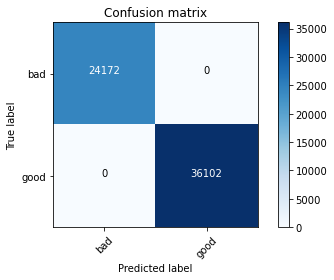

In [24]:
plt.figure()
plot_confusion_matrix(cm_train_subsample, classes=['bad','good'], title='Confusion matrix')

### 4.4.2 quickie evaluation on full training data

Subsampled training set used to make the model excluded 14 of every 15 "good" class observations.  If I feed the model the original training data with all good and bad observations, what fraction of the new good observations are correctly classified?

Confusion matrix
[[ 24172      0]
 [ 27887 513649]]


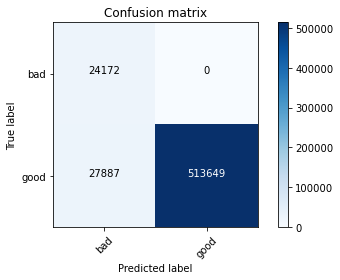

In [25]:
# predict on full training set (most of the good class not used in model building)
# remember to fill in missing values using new function
y_train_prediction = model.predict(X_train)
cm_train = confusion_matrix(y_train, y_train_prediction)
plt.figure()
plot_confusion_matrix(cm_train, classes=['bad','good'], title='Confusion matrix')

Confusion matrix
[[ 14722   9450]
 [ 12970 528566]]


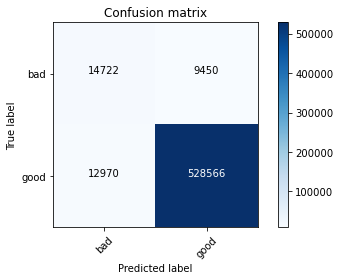

In [26]:
# Let's see if the model did a better job predicting y_train than just a single feature 'OriginalCT.recommended_True' in the model:
# sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)
cm_single_feature = confusion_matrix(y_train, X_train['OriginalCT.recommended_True'])
plt.figure()
plot_confusion_matrix(cm_single_feature, classes=['bad','good'], title='Confusion matrix')

It appears that before hyperparameter tuning and cross validation, a lower fraction of True "good" were correctly labeled with RandomForest than just using a single binary feature 'OriginalCT.recommended_True' as the predictor.  This is problematic.

Since every True "bad" observation was used to train the random forest, it's no surprise that the prediction of the same observations will be accurate.